# Team Members:
- Amir Mobayen
- Leelav Kareem
- Nikita Chistyakov

## Topic:

## Libraries

In [1]:
# Basic packages
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

tf.get_logger().setLevel('ERROR')


2023-07-15 17:14:41.095239: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# About the dataset:
List of tweet texts with emotion labels like joy, sadness, fear, anger…
Dataset is split into train, test and validation sets for building the machine learning model. At first, you are
given only train and test sets. The validation one will be given in the end of the project for you to check
the final performance of your algorithm (to make sure there is no overfitting over the test data).
You can work on this project on group of one, two or three students. This exercise is mandatory, not
giving it back is equivalent to getting to lowest grade

# Goal:
- Train different kind of models able to classify each text according to the sentiment mainly present
in it
- Compare the results of your different models and try to analyze and explain the differences

# Parameters

In [2]:
data_file = './NLP_exam_emotions_dataset/train.txt'
test_flie = './NLP_exam_emotions_dataset/test.txt'

# Preparing Dataset

In [3]:
train_data = pd.read_csv(data_file, delimiter=';', header=0)
test_data = pd.read_csv(test_flie, delimiter=';', header=0)

train_data.head(), test_data.head()

(                             i didnt feel humiliated  sadness
 0  i can go from feeling so hopeless to so damned...  sadness
 1   im grabbing a minute to post i feel greedy wrong    anger
 2  i am ever feeling nostalgic about the fireplac...     love
 3                               i am feeling grouchy    anger
 4  ive been feeling a little burdened lately wasn...  sadness,
   im feeling rather rotten so im not very ambitious right now  sadness
 0          im updating my blog because i feel shitty           sadness
 1  i never make her separate from me because i do...           sadness
 2  i left with my bouquet of red and yellow tulip...               joy
 3    i was feeling a little vain when i did this one           sadness
 4  i cant walk into a shop anywhere where i do no...              fear)

In [4]:
train_data.info(), test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15999 entries, 0 to 15998
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   i didnt feel humiliated  15999 non-null  object
 1   sadness                  15999 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 2 columns):
 #   Column                                                       Non-Null Count  Dtype 
---  ------                                                       --------------  ----- 
 0   im feeling rather rotten so im not very ambitious right now  1999 non-null   object
 1   sadness                                                      1999 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


(None, None)

In [5]:
def tokenizer(text):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    max_len = max([len(seq) for seq in sequences])
    vocab_size = len(tokenizer.word_index) + 1
    return pad_sequences(sequences, maxlen=max_len), max_len, vocab_size

In [6]:
train_x, max_len, vocab_size = tokenizer(train_data.iloc[:,0])
test_x, _, _ = tokenizer(test_data.iloc[:,0])

In [7]:
label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(train_data.iloc[:,1])
test_y = label_encoder.transform(test_data.iloc[:,1])

train_y, test_y

(array([4, 0, 3, ..., 2, 0, 4]), array([4, 4, 2, ..., 2, 2, 1]))

# Model

In [8]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 100, input_length=max_len))
model.add(tf.keras.layers.Conv1D(256, 5, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 100)           1521300   
                                                                 
 conv1d (Conv1D)             (None, 62, 256)           128256    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                        

2023-07-15 17:14:42.588709: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
tf.keras.backend.clear_session()

early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_x, train_y, epochs=30, batch_size=16, validation_split=0.2, callbacks=[early])

Epoch 1/30
800/800 [==============================] - 21s 26ms/step - loss: 0.7826 - accuracy: 0.7056 - val_loss: 0.2179 - val_accuracy: 0.9159
Epoch 2/30
800/800 [==============================] - 21s 27ms/step - loss: 0.1530 - accuracy: 0.9390 - val_loss: 0.1976 - val_accuracy: 0.9216
Epoch 3/30
800/800 [==============================] - 21s 26ms/step - loss: 0.0841 - accuracy: 0.9666 - val_loss: 0.2194 - val_accuracy: 0.9231
Epoch 4/30
800/800 [==============================] - 21s 27ms/step - loss: 0.0533 - accuracy: 0.9805 - val_loss: 0.2682 - val_accuracy: 0.9184
Epoch 5/30
800/800 [==============================] - 21s 26ms/step - loss: 0.0327 - accuracy: 0.9880 - val_loss: 0.2906 - val_accuracy: 0.9162
Epoch 6/30
800/800 [==============================] - 21s 26ms/step - loss: 0.0298 - accuracy: 0.9895 - val_loss: 0.3094 - val_accuracy: 0.9197
Epoch 7/30
800/800 [==============================] - 21s 26ms/step - loss: 0.0171 - accuracy: 0.9949 - val_loss: 0.3877 - val_accuracy:

# Evaluation

In [10]:
loss, accuracy = model.evaluate(test_x, test_y)

print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

63/63 [==============================] - 0s 6ms/step - loss: 4.4858 - accuracy: 0.2546
Test Loss: 4.485814094543457
Test Accuracy: 0.2546273171901703


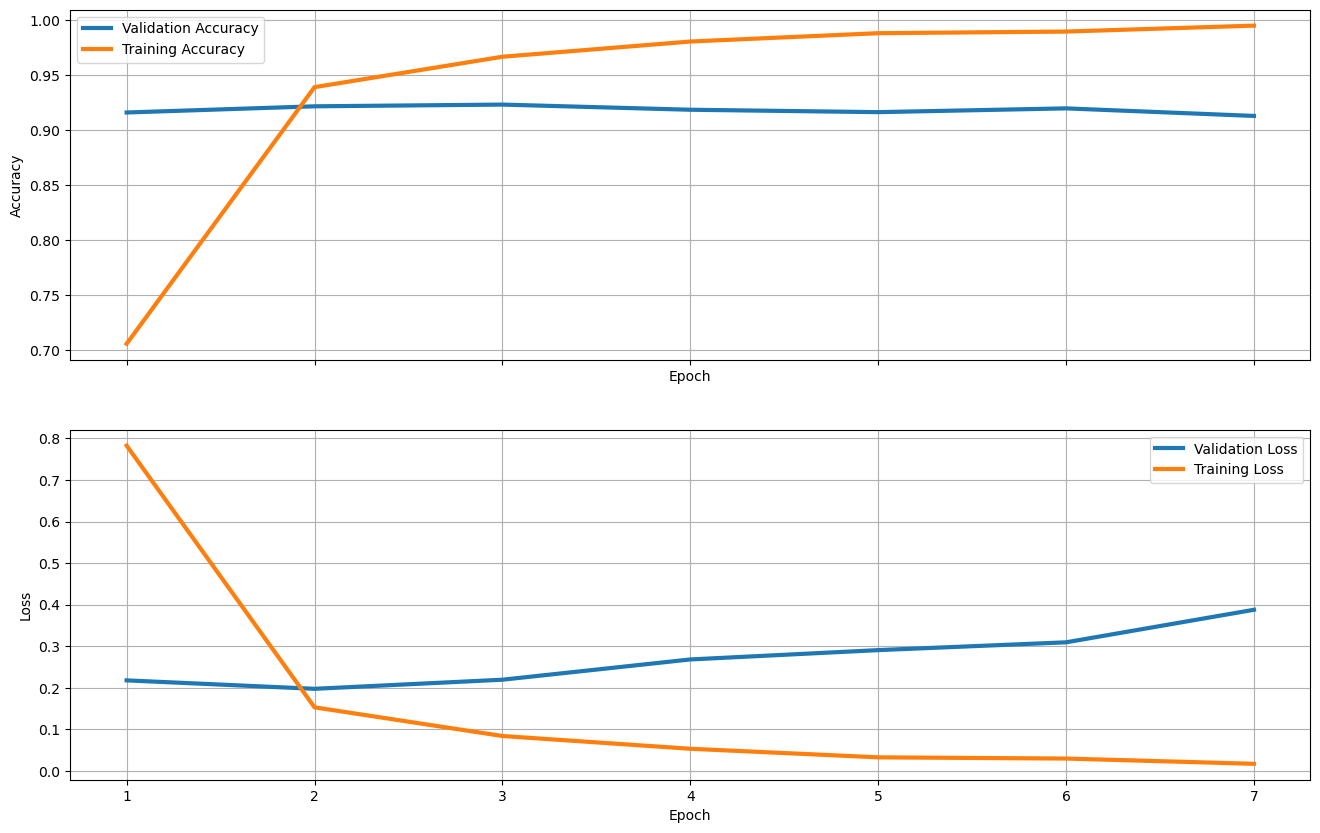

In [11]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns = ["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df) + 1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show();

plot_results(history)

# Sample Test

In [12]:
sample = test_data.iloc[0, 0]
sample_test, _, _ = tokenizer([sample])  # Tokenize the sample as a list

sample_test = pad_sequences(sample_test, maxlen=max_len)  # Pad the sequence to match max_len
test_predict = model.predict(sample_test)
prediction = np.argmax(test_predict)

# After obtaining the predicted class index
predicted_label = label_encoder.inverse_transform([prediction])[0]
true_label = test_data.iloc[0, 1]

print("Predicted class:", predicted_label)
print("True class:", true_label)



1/1 [==============================] - 0s 48ms/step
Predicted class: anger
True class: sadness
